<a href="https://colab.research.google.com/github/bpriantti/projeto_ml_classifier_xgboosting_forecasting_returns_gbpusd/blob/main/9_Projeto_Ml_Classifier_XGboosting_Forecasting_Returns_GBPUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Ml Classifier XGboosting Forecasting Returns - GBP-USD

__Bussines Problem:__

> Acertar o melhor momento para realizar uma operação de investimento não é uma tarefa fácil, muitas vezes tentar utilizar estratégias de investimento de forma discricionária pode causar prejuízos financeiros a investidores de grande e pequeno porte, de posse desta informação decidiu-se por meio de técnicas de machine learning desenvolver um modelo quantitativo para prever a direção do ativo GBP-USD(libra esterlina dólar) em comprar, vender e esperar, e por meio da tecnologia e data science conseguir melhor resultados de investimento.

__Objetivo:__

> Desenvolver um modelo de machine learning para prever o retorno futuro em 2 dias do ativo GBP-USD, classificando os retornos em alta, baixa e esperar, com base em critérios com base em um threshold definido com base na distribuição dos retornos. Neste projeto optou-se por utilizar o algoritmo de XGboosting.

__Autor:__  
   - Bruno Priantti.
    
__Contato:__  
  - bpriantti@gmail.com

__Encontre-me:__  
   -  https://www.linkedin.com/in/bpriantti/  
   -  https://github.com/bpriantti
   -  https://www.instagram.com/brunopriantti/
   
__Frameworks Utilizados:__

- Numpy: https://numpy.org/doc/  
- Pandas: https://pandas.pydata.org/
- Matplotlib: https://matplotlib.org/ 
- Seaborn: https://seaborn.pydata.org/  
- Plotly: https://plotly.com/  
- Scikit learn: https://scikit-learn.org/stable/index.html
- Statsmodels: https://www.statsmodels.org/stable/index.html
- TA-lib: https://mrjbq7.github.io/ta-lib/doc_index.html
___


### non-native libs:

In [ ]:
!pip install -q talib-binary

     |████████████████████████████████| 2.4 MB 21.2 MB/s 


### user-funtions:


In [ ]:
def performEval(stop, backtest_):

    backtest = backtest_.copy()

    # ajustando o retorno em pips com o resultado do modelo:
    backtest.loc[: , "ret_pips"] = np.where(backtest.loc[: , 'pred'] ==  1 ,    backtest.loc[: ,'target_pips'], '0')
    backtest.loc[: , "ret_pips"] = np.where(backtest.loc[: , 'pred'] == -1 , -1*backtest.loc[: ,'target_pips'], backtest.loc[: , "ret_pips"])
    backtest.loc[: , "ret_pips"] = backtest["ret_pips"].astype(float)

    # simulando um stop
    stop = stop
    backtest.loc[: , "ret_pips"] = np.where(backtest.loc[: , 'ret_pips'] <= -stop , -stop, backtest.loc[: , "ret_pips"])

    backtest.loc[: , "ret_pips_acc"] = backtest["ret_pips"].cumsum()

    fig = px.line(backtest, y='ret_pips_acc')


    fig.update_layout(width = 960, height = 500
                     ,template = 'plotly_dark'
                     ,title = 'performance backtest:'
                     ,xaxis_rangeslider_visible=False)
    fig.show()

    return backtest.loc[: , "ret_pips_acc"], backtest.loc[: , "ret_pips"]

### import libs:

In [ ]:
#import libs:
import pandas as pd
import numpy as np

#libs para visualization dos dados:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md

#---:
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objects as Dash
from plotly.subplots import make_subplots

#lib para api com ativos da bolsa:
import talib as ta

#---
import warnings
warnings.filterwarnings("ignore")

### database download:

In [ ]:
url = 'https://raw.githubusercontent.com/bpriantti/projeto_ml_classifier_forecasting_returns_model_eval/main/files/GBPUSD_Daily_199305120000_202208030000.csv'
data = pd.read_csv(url,sep = '\t')

In [ ]:
data.head()

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,1993.05.12,1.5370,1.5445,1.5290,1.5338,2781,0,50
1,1993.05.13,1.5328,1.5360,1.5180,1.5225,2571,0,50
2,1993.05.14,1.5228,1.5415,1.5200,1.5387,2711,0,50
3,1993.05.17,1.5365,1.5460,1.5309,1.5355,2921,0,50
4,1993.05.18,1.5350,1.5380,1.5237,1.5365,2711,0,50


### wralling:

In [ ]:
data.columns = ['date', 'open','high','low','close','tickvol','vol','spread']
data.drop(['tickvol','vol'],axis = 1, inplace = True)

In [ ]:
data.head()

,date,open,high,low,close,spread
0,1993.05.12,1.5370,1.5445,1.5290,1.5338,50
1,1993.05.13,1.5328,1.5360,1.5180,1.5225,50
2,1993.05.14,1.5228,1.5415,1.5200,1.5387,50
3,1993.05.17,1.5365,1.5460,1.5309,1.5355,50
4,1993.05.18,1.5350,1.5380,1.5237,1.5365,50


- wralling data:

In [ ]:
data['Date'] = pd.to_datetime(data['date']).to_frame()
data.set_index(data['Date'],inplace = True)

data.drop(['Date','date'],axis =1, inplace = True)

data = data['1995':]

### visualization:

In [ ]:
fig = go.Figure()
    
fig.add_trace(go.Candlestick(
              x=data.index,
              open=data['open'], 
              high=data['high'],
              low=data['low'], 
              close=data['close']))

fig.update_layout(width = 1000
                 ,template = 'plotly_dark'
                 ,title = 'GBP-USD - 1995 to 2022'
                 ,xaxis_rangeslider_visible=False)
fig.show()

### feature eng:

In [ ]:
database = data.copy()

In [ ]:
# Construcao dos alvos
periodos = 2

# Alvo 1 - Retorno
database["target"] = database["close"].pct_change(periodos).shift(-periodos)

# Variaçao em Pips do alvo
database["target_pips"] = ((database["close"] - database["close"].shift(periodos))*10000).shift(-periodos)

In [ ]:
#plot-data:
fig = go.Figure(data=[go.Histogram(x=database['target_pips'])])

fig.add_shape(type="line",
              x0=50, y0=0, x1=50, y1=400,
              line=dict(
                  color="red",
                  width=2,
                  dash="dot"))

fig.add_shape(type="line",
              x0=-50, y0=0, x1=-50, y1=400,
              line=dict(
                  color="red",
                  width=2,
                  dash="dot"))
#---:
space = 0.2

# add annotation
fig.add_annotation(dict(font=dict(color='white',size=15),
                                        x=0.2 + space,
                                        y=0.8,
                                        showarrow=False,
                                        text="Target Value = -1",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

# add annotation
fig.add_annotation(dict(font=dict(color='white',size=15),
                                        x=0.4 + space,
                                        y=0.9,
                                        showarrow=False,
                                        text="Target Value = 0",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

# add annotation
fig.add_annotation(dict(font=dict(color='white',size=15),
                                        x=0.6 + space,
                                        y=0.8,
                                        showarrow=False,
                                        text="Target Value = 1",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

fig.update_layout(height=500, width=1000,
                  template = 'plotly_dark',
                  title_text="Target Var Distribuition : ")

fig.show()

In [ ]:
# criacao do alvo binario:
database["target_bin"] = np.where(database['target_pips'] >  50 , 1, 0)
database["target_bin"] = np.where(database['target_pips'] < -50 ,-1, database['target_bin'])

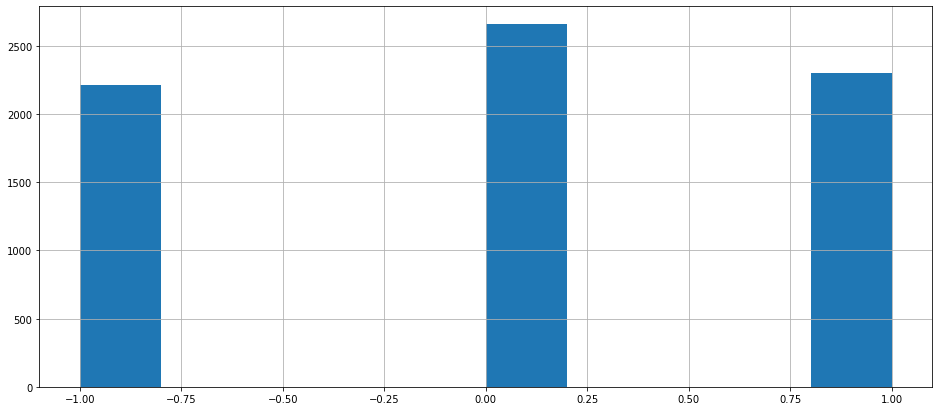

In [ ]:
database["target_bin"].hist(figsize = (16,7))

### feature engineering:

In [ ]:
def calc_features(df1):

    df1['var_1'] = ta.ADX(df1['high'],df1['low'],df1['close'],14)
    df1['var_2'] = ta.PLUS_DI(df1['high'],df1['low'],df1['close'],14)
    df1['var_3'] = ta.MINUS_DI(df1['high'],df1['low'],df1['close'],14)

    df1.dropna(inplace = True)
    return df1

dados = calc_features(database.copy())

In [ ]:
dados.head()

,open,high,low,close,spread,target,target_pips,target_bin,var_1,var_2,var_3
Date,,,,,,,,,,,
1995-02-08,1.5550,1.5606,1.5491,1.5542,50,0.004697,73.0,1,26.908119,12.561433,24.297602
1995-02-09,1.5536,1.5615,1.5520,1.5580,50,0.002888,45.0,0,27.115458,12.384355,22.904166
1995-02-10,1.5570,1.5673,1.5527,1.5615,50,0.000640,10.0,0,26.412884,14.754538,20.918660
1995-02-13,1.5625,1.5666,1.5607,1.5625,50,-0.000832,-13.0,0,25.760494,14.218144,20.158173
1995-02-14,1.5622,1.5655,1.5514,1.5625,50,0.010240,160.0,1,26.053981,13.001655,24.076711


histogram:

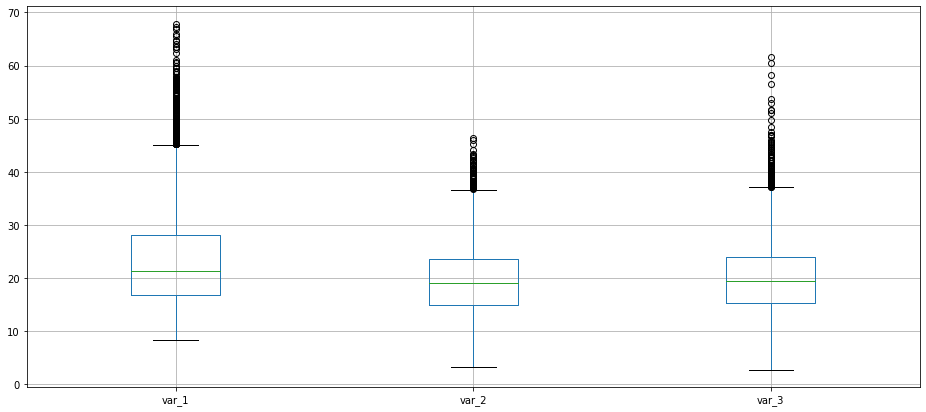

In [ ]:
dados.loc[:,'var_1':].boxplot(figsize = (16,7));

### analise correl:

In [ ]:
dados.loc[:,'var_1':].corr()

,var_1,var_2,var_3
var_1,1.000000,-0.001075,0.101710
var_2,-0.001075,1.000000,-0.669124
var_3,0.101710,-0.669124,1.000000


### data split train-test:

In [ ]:
dados.head()

,open,high,low,close,spread,target,target_pips,target_bin,var_1,var_2,var_3
Date,,,,,,,,,,,
1995-02-08,1.5550,1.5606,1.5491,1.5542,50,0.004697,73.0,1,26.908119,12.561433,24.297602
1995-02-09,1.5536,1.5615,1.5520,1.5580,50,0.002888,45.0,0,27.115458,12.384355,22.904166
1995-02-10,1.5570,1.5673,1.5527,1.5615,50,0.000640,10.0,0,26.412884,14.754538,20.918660
1995-02-13,1.5625,1.5666,1.5607,1.5625,50,-0.000832,-13.0,0,25.760494,14.218144,20.158173
1995-02-14,1.5622,1.5655,1.5514,1.5625,50,0.010240,160.0,1,26.053981,13.001655,24.076711


In [ ]:
#x-y split:
y = dados.loc[:,'target_pips':'target_bin']
X = dados.loc[:,'var_1':]

# Vamos treinar o modelo de 2009 a 2013
start_train = '1995'
end_train   = '2010'

# Vamos testar o modelo de 2014 a 2019
start_test = '2011'

y_train = y[start_train:end_train]
y_test  = y[start_test:]

x_train = X[start_train:end_train]
x_test  = X[start_test:] 

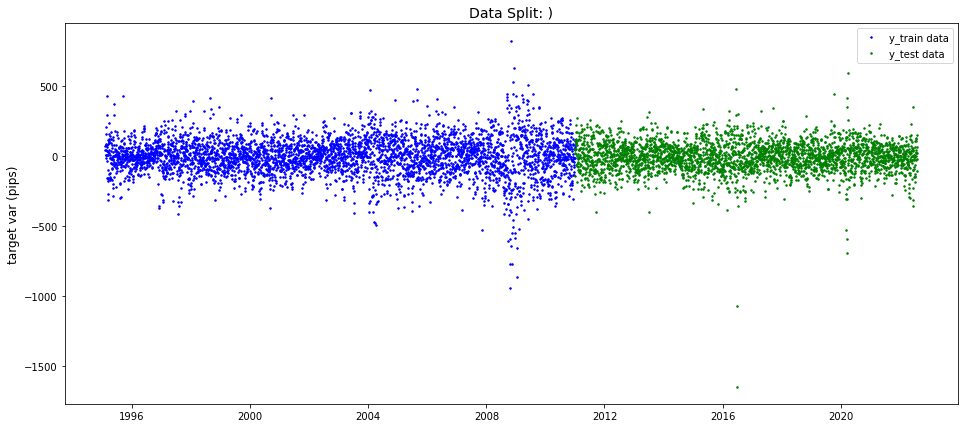

In [ ]:
# Plot the data
plt.figure(figsize = (16,7))
plt.plot(y_train['target_pips'], linestyle='None', marker='.', markersize=3.0, label='y_train data', color='blue')
plt.plot(y_test['target_pips'], linestyle='None', marker='.', markersize=3.0, label='y_test data', color='green')

# Set the title and axis label
plt.title("Data Split: )",fontsize=14)
#plt.xlabel('Years', fontsize=12)
plt.ylabel('target var (pips)', fontsize=12)

# Display the plot
plt.legend()
plt.show()

### train xgboosting:

In [ ]:
#import XGBoost:
import xgboost as xgb
from xgboost import XGBClassifier

#parameters:
params = {
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100,
            'ramdom_state':42
         }
            
#instanciando xgboosting:
xgb_clf = XGBClassifier(**params)

#fit:
xgb_clf.fit(x_train, y_train['target_bin'])

#parameters:
print(xgb_clf)

#prediçoes para o treinamento e teste:
y_train['pred'] = xgb_clf.predict(x_train)
y_test['pred']  = xgb_clf.predict(x_test)

#---:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#---:
print("------------------------------------------------------")
print('classification_report: train')
print(classification_report(y_train['target_bin'], y_train['pred']))
print("------------------------------------------------------")
print('classification_report: test')
print(classification_report(y_test['target_bin'], y_test['pred']))

XGBClassifier(alpha=10, learning_rate=1.0, max_depth=4,
              objective='multi:softprob', ramdom_state=42)
------------------------------------------------------
classification_report: train
              precision    recall  f1-score   support

          -1       0.92      0.89      0.91      1296
           0       0.89      0.93      0.91      1444
           1       0.91      0.90      0.91      1396

    accuracy                           0.91      4136
   macro avg       0.91      0.91      0.91      4136
weighted avg       0.91      0.91      0.91      4136

------------------------------------------------------
classification_report: test
              precision    recall  f1-score   support

          -1       0.30      0.33      0.31       908
           0       0.42      0.33      0.37      1200
           1       0.30      0.36      0.33       899

    accuracy                           0.34      3007
   macro avg       0.34      0.34      0.34      3007
weighted av

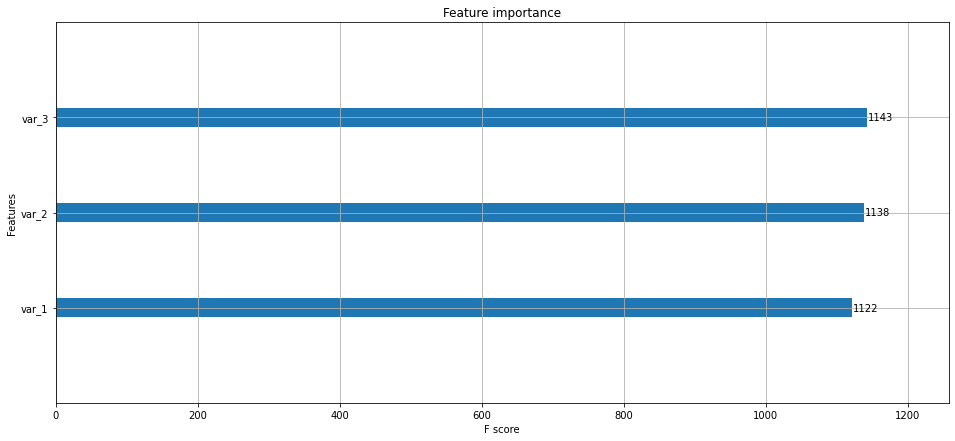

<Figure size 1152x504 with 0 Axes>

In [ ]:
xgb.plot_importance(xgb_clf)
plt.figure(figsize = (16,7))
plt.show()

In [ ]:
equity_1, pnl_1 = performEval(90, y_test)

### hyper tunning - research:


1  - 2  - 3  - 4  - 5  - 6  - 7  - 8  - 9  - 10  - 

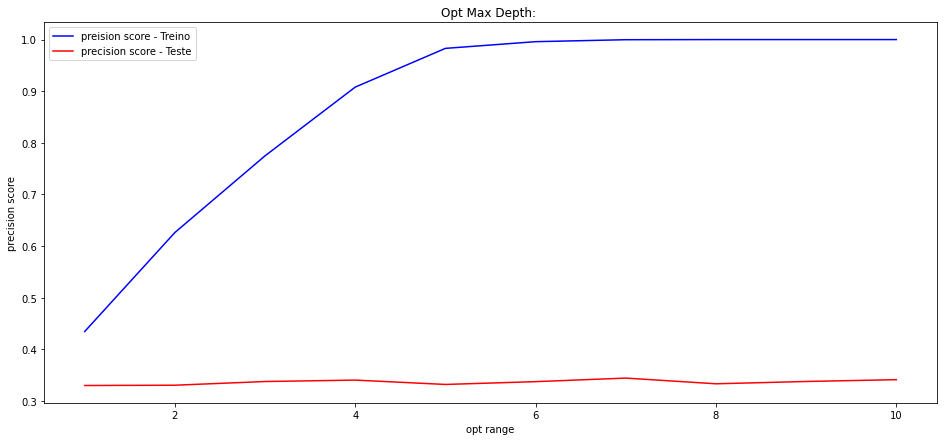

In [ ]:
opt_range = [1,2,3,4,5,6,7,8,9,10]

train_results = []
test_results = []

#eval model:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

for i in opt_range:

    print(i, " -", end =" ")

    #declare parameters:
    params = {
            'max_depth': i,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100,
            'ramdom_state':42
            }
                
    #instantiate the classifier:
    xgb_clf = XGBClassifier(**params)

    #fit the classifier to the training data:
    xgb_clf.fit(x_train, y_train['target_bin'])

    #prediçoes para o treinamento e teste:
    y_train['pred'] = xgb_clf.predict(x_train)
    y_test['pred']  = xgb_clf.predict(x_test)

    #precision score:
    precision_score_train = precision_score(y_train['target_bin'], y_train['pred'], average='macro')
    precision_score_test  = precision_score(y_test['target_bin'], y_test['pred'], average='macro')

    #recall score:
    recall_score_train = recall_score(y_train['target_bin'], y_train['pred'], average='macro')
    recall_score_test  = recall_score(y_test['target_bin'], y_test['pred'], average='macro')

    #accuracy score:
    accuracy_score_train = accuracy_score(y_train['target_bin'], y_train['pred'])
    accuracy_score_test  = accuracy_score(y_test['target_bin'], y_test['pred'])
    #---:
    train_results.append([precision_score_train, recall_score_train, accuracy_score_train])
    test_results.append([precision_score_test, recall_score_test, accuracy_score_test])

train_results = pd.DataFrame(train_results)
test_results = pd.DataFrame(test_results)

plt.figure(figsize = (16,7))
line1, = plt.plot(opt_range, train_results[1], "b", label = "preision score - Treino")
line2, = plt.plot(opt_range, test_results[1], "r", label = "precision score - Teste")

plt.ylabel("precision score")
plt.xlabel("opt range")
plt.legend()
plt.title("Opt Max Depth: ")
plt.show()

1  - 5  - 10  - 20  - 30  - 40  - 50  - 

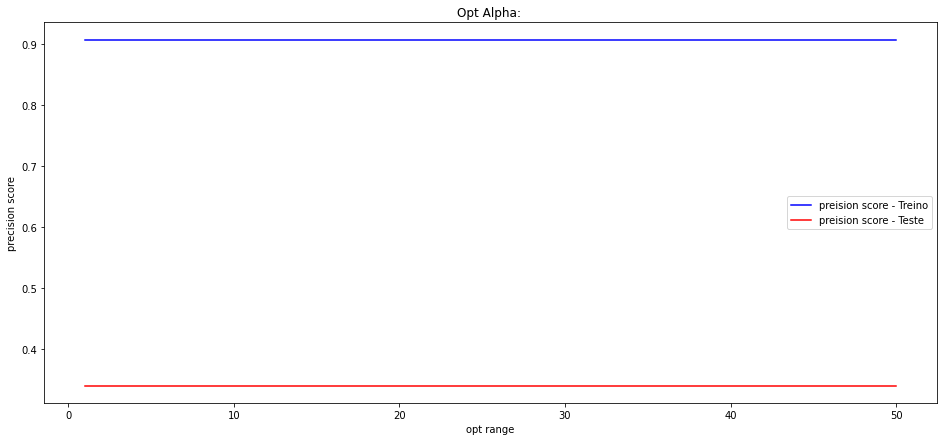

In [ ]:
opt_range = [1,5,10,20,30,40,50]

train_results = []
test_results = []

#eval model:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

for i in opt_range:

    print(i, " -", end =" ")

    #declare parameters:
    params = {
            'max_depth': 4,
            'alpha': i,
            'learning_rate': 1.0,
            'n_estimators':100,
            'ramdom_state':42
            }
                
    #instantiate the classifier:
    xgb_clf = XGBClassifier(**params)

    #fit the classifier to the training data:
    xgb_clf.fit(x_train, y_train['target_bin'])

    #prediçoes para o treinamento e teste:
    y_train['pred'] = xgb_clf.predict(x_train)
    y_test['pred']  = xgb_clf.predict(x_test)

    #precision score:
    precision_score_train = precision_score(y_train['target_bin'], y_train['pred'], average='macro')
    precision_score_test  = precision_score(y_test['target_bin'], y_test['pred'], average='macro')

    #recall score:
    recall_score_train = recall_score(y_train['target_bin'], y_train['pred'], average='macro')
    recall_score_test  = recall_score(y_test['target_bin'], y_test['pred'], average='macro')

    #accuracy score:
    accuracy_score_train = accuracy_score(y_train['target_bin'], y_train['pred'])
    accuracy_score_test  = accuracy_score(y_test['target_bin'], y_test['pred'])
    #---:
    train_results.append([precision_score_train, recall_score_train, accuracy_score_train])
    test_results.append([precision_score_test, recall_score_test, accuracy_score_test])

train_results = pd.DataFrame(train_results)
test_results = pd.DataFrame(test_results)

plt.figure(figsize = (16,7))
line1, = plt.plot(opt_range, train_results[1], "b", label = "preision score - Treino")
line2, = plt.plot(opt_range, test_results[1], "r", label = "preision score - Teste")

plt.ylabel("precision score")
plt.xlabel("opt range")
plt.legend()
plt.title("Opt Alpha: ")

plt.show()

0.1  - 0.2  - 0.3  - 0.4  - 0.5  - 0.6  - 0.7  - 0.8  - 0.9  - 1  - 

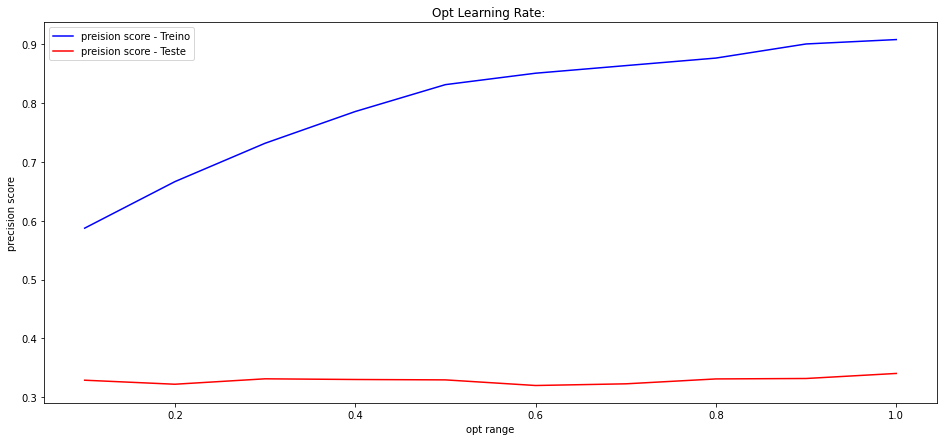

In [ ]:
opt_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

train_results = []
test_results = []

#eval model:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

for i in opt_range:

    print(i, " -", end =" ")

    #declare parameters:
    params = {
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': i,
            'n_estimators':100,
            'ramdom_state':42
            }
                
    #instantiate the classifier:
    xgb_clf = XGBClassifier(**params)

    #fit the classifier to the training data:
    xgb_clf.fit(x_train, y_train['target_bin'])

    #prediçoes para o treinamento e teste:
    y_train['pred'] = xgb_clf.predict(x_train)
    y_test['pred']  = xgb_clf.predict(x_test)

    #precision score:
    precision_score_train = precision_score(y_train['target_bin'], y_train['pred'], average='macro')
    precision_score_test  = precision_score(y_test['target_bin'], y_test['pred'], average='macro')

    #recall score:
    recall_score_train = recall_score(y_train['target_bin'], y_train['pred'], average='macro')
    recall_score_test  = recall_score(y_test['target_bin'], y_test['pred'], average='macro')

    #accuracy score:
    accuracy_score_train = accuracy_score(y_train['target_bin'], y_train['pred'])
    accuracy_score_test  = accuracy_score(y_test['target_bin'], y_test['pred'])
    #---:
    train_results.append([precision_score_train, recall_score_train, accuracy_score_train])
    test_results.append([precision_score_test, recall_score_test, accuracy_score_test])

train_results = pd.DataFrame(train_results)
test_results = pd.DataFrame(test_results)

plt.figure(figsize = (16,7))
line1, = plt.plot(opt_range, train_results[1], "b", label = "preision score - Treino")
line2, = plt.plot(opt_range, test_results[1], "r", label = "preision score - Teste")

plt.ylabel("precision score")
plt.xlabel("opt range")
plt.legend()
plt.title("Opt Learning Rate: ")

plt.show()

50  - 100  - 500  - 1000  - 

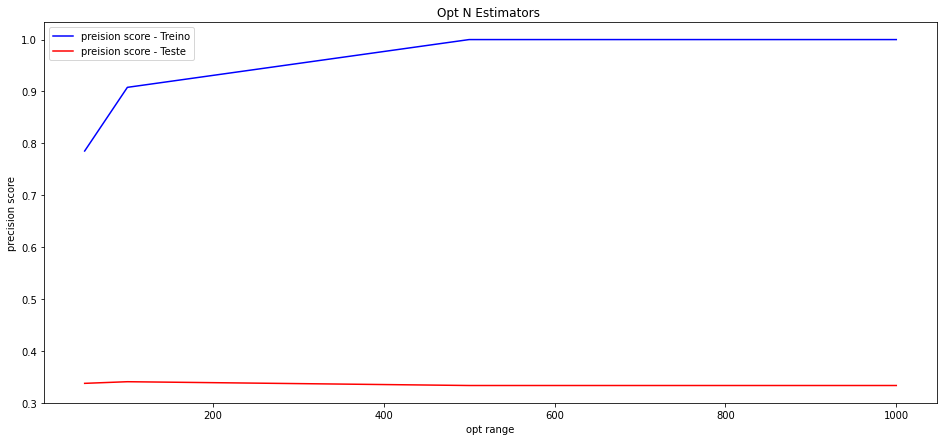

In [ ]:
opt_range = [50,100,500,1000]

train_results = []
test_results = []

#eval model:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

for i in opt_range:

    print(i, " -", end =" ")

    #declare parameters:
    params = {
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':i,
            'ramdom_state':42
            }
                
    #instantiate the classifier:
    xgb_clf = XGBClassifier(**params)

    #fit the classifier to the training data:
    xgb_clf.fit(x_train, y_train['target_bin'])

    #prediçoes para o treinamento e teste:
    y_train['pred'] = xgb_clf.predict(x_train)
    y_test['pred']  = xgb_clf.predict(x_test)

    #precision score:
    precision_score_train = precision_score(y_train['target_bin'], y_train['pred'], average='macro')
    precision_score_test  = precision_score(y_test['target_bin'], y_test['pred'], average='macro')

    #recall score:
    recall_score_train = recall_score(y_train['target_bin'], y_train['pred'], average='macro')
    recall_score_test  = recall_score(y_test['target_bin'], y_test['pred'], average='macro')

    #accuracy score:
    accuracy_score_train = accuracy_score(y_train['target_bin'], y_train['pred'])
    accuracy_score_test  = accuracy_score(y_test['target_bin'], y_test['pred'])
    #---:
    train_results.append([precision_score_train, recall_score_train, accuracy_score_train])
    test_results.append([precision_score_test, recall_score_test, accuracy_score_test])

train_results = pd.DataFrame(train_results)
test_results = pd.DataFrame(test_results)

plt.figure(figsize = (16,7))
line1, = plt.plot(opt_range, train_results[1], "b", label = "preision score - Treino")
line2, = plt.plot(opt_range, test_results[1], "r", label = "preision score - Teste")

plt.ylabel("precision score")
plt.xlabel("opt range")
plt.legend()
plt.title("Opt N Estimators ")
plt.show()

### re-fit model:

In [ ]:
#melhor otimizacao:
optvar1 = [1,2,3,4,5,6,7,8,9,10]

optvar2 = [10,50,100,200,300,400,600]

train_results = []
test_results = []

#eval model:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

bestfit = []

for i in optvar1:

  for j in optvar2:s
      #declare parameters:
      params = {
              'max_depth': i,
              'alpha': 10,
              'learning_rate': 1.0,
              'n_estimators':j,
              'ramdom_state':42
              }
                  
      #instantiate the classifier:
      xgb_clf = XGBClassifier(**params)

      #fit the classifier to the training data:
      xgb_clf.fit(x_train, y_train['target_bin'])

      #prediçoes para o treinamento e teste:
      y_train['pred'] = xgb_clf.predict(x_train)
      y_test['pred']  = xgb_clf.predict(x_test)

      #precision score:
      precision_score_train = precision_score(y_train['target_bin'], y_train['pred'], average='macro')
      precision_score_test  = precision_score(y_test['target_bin'], y_test['pred'], average='macro')

      #recall score:
      recall_score_train = recall_score(y_train['target_bin'], y_train['pred'], average='macro')
      recall_score_test  = recall_score(y_test['target_bin'], y_test['pred'], average='macro')

      #accuracy score:
      accuracy_score_train = accuracy_score(y_train['target_bin'], y_train['pred'])
      accuracy_score_test  = accuracy_score(y_test['target_bin'], y_test['pred'])
      #---:
      train_results.append([precision_score_train, recall_score_train, accuracy_score_train])
      test_results.append([precision_score_test, recall_score_test, accuracy_score_test])

      #---:
      bestfit.append([i,j,accuracy_score_train,accuracy_score_test])

In [ ]:
bestfit2 = pd.DataFrame(bestfit)
bestfit2.columns = ['i','j','train','test']

#rank best fit:
bestfit2.sort_values(by=['test'], ascending=False).head(5)

,i,j,train,test
44,7,100,0.999758,0.343199
57,9,50,0.999758,0.342202
36,6,50,0.947776,0.342202
63,10,10,0.891199,0.341536
65,10,100,1.000000,0.339541


### backtest:

In [ ]:
#declare parameters:
params = {
            'max_depth': 7,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100,
            'ramdom_state':42
         }
            
#instantiate the classifier:
xgb_clf = XGBClassifier(**params)

#fit the classifier to the training data:
xgb_clf.fit(x_train, y_train['target_bin'])

#alternatively view the parameters of the xgb trained model:
print(xgb_clf)

#prediçoes para o treinamento e teste:
y_train['pred'] = xgb_clf.predict(x_train)
y_test['pred']  = xgb_clf.predict(x_test)

#---:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#---:
print("------------------------------------------------------")
print('classification_report: train')
print(classification_report(y_train['target_bin'], y_train['pred']))
print("------------------------------------------------------")
print('classification_report: test')
print(classification_report(y_test['target_bin'], y_test['pred']))

XGBClassifier(alpha=10, learning_rate=1.0, max_depth=7,
              objective='multi:softprob', ramdom_state=42)
------------------------------------------------------
classification_report: train
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1296
           0       1.00      1.00      1.00      1444
           1       1.00      1.00      1.00      1396

    accuracy                           1.00      4136
   macro avg       1.00      1.00      1.00      4136
weighted avg       1.00      1.00      1.00      4136

------------------------------------------------------
classification_report: test
              precision    recall  f1-score   support

          -1       0.31      0.33      0.32       908
           0       0.41      0.33      0.37      1200
           1       0.31      0.37      0.34       899

    accuracy                           0.34      3007
   macro avg       0.34      0.34      0.34      3007
weighted av

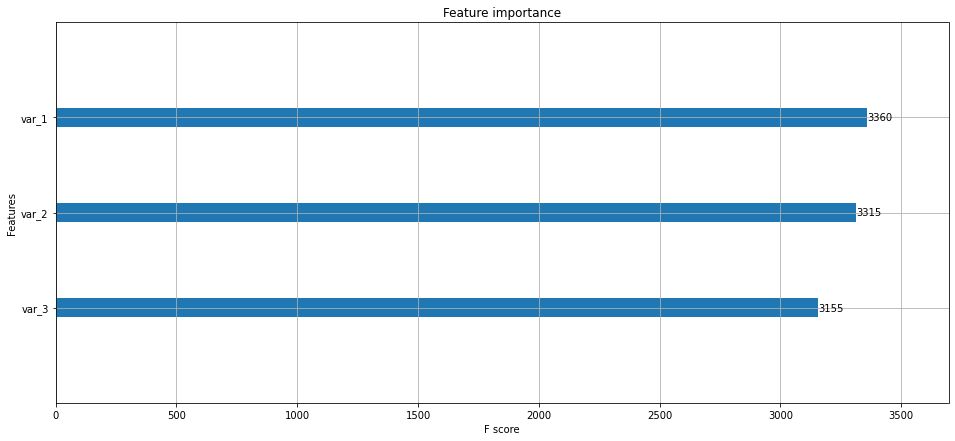

In [ ]:
xgb.plot_importance(xgb_clf)
plt.figure(figsize = (16,7))
plt.show()

In [ ]:
equity_2, pnl_2 = performEval(90, y_test)

### comparando modelos:

In [ ]:
# Create traces:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x = equity_1.index,
                    y=equity_1,
                    mode='lines',
                    name='no opt'))

fig.add_trace(go.Scatter(
                    x = equity_1.index,
                    y=equity_2,
                    mode='lines',
                    name='with opt'))

fig.update_layout(width = 960, height = 550
                  ,template = 'plotly_dark'
                  ,title = 'equity: gbp model v43'
                  ,xaxis_rangeslider_visible=False)
fig.show()

In [ ]:
#---:
pnl1 = pnl_1.to_frame()
pnl2 = pnl_2.to_frame()

pnl1 = pnl_1.reset_index()
pnl2 = pnl_2.reset_index()

pnl1 = pnl1.resample('Y', on='Date').sum()
pnl2 = pnl2.resample('Y', on='Date').sum()

#---:
years = ['2011', '2012', '2013', '2014', '2015', '2016','2017', '2018', '2019', '2020', '2021', '2022']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=years,
    y=pnl1['ret_pips'],
    name='no opt',
))

fig.add_trace(go.Bar(
    x=years,
    y=pnl2['ret_pips'],
    name='with opt',
))

fig.update_layout(width = 960, height = 550
                  ,template = 'plotly_dark'
                  ,title = 'Pips Anual Return: '
                  ,xaxis_rangeslider_visible=False
                  ,barmode='group')

fig.update_yaxes(range=[-2000, 6000])

fig.show()